Here is a step by step explanation of what is going on:  
Generation of n particles. 
Using the following function, I calculate for the [initial density](https://pmocz.github.io/manuscripts/pmocz_sph.pdf) for each individual particle.:  
$$ \rho_a = \sum_{b} m_b \cdot \nabla W(r_a - r_b ; h)$$
$a$ is my "main" particle, and $b$ is all my other particles. $m$ is my mass. $r$ refers to the position of the particle. $h$ refers to the smoothing length (currently set at 1 as default)  
  
  
[$\nabla W(r)$ uses the following equation](https://pmocz.github.io/manuscripts/pmocz_sph.pdf):  
$$\nabla W(r) = -\frac{2e^{\frac{-|r|^2}{h^2}} \cdot r} {h^{2+d} \cdot \pi^{\frac{d}{2}}}$$ 
Where $d = 3$ because 3 dimension.  
  
Upon calculation of $\rho$, we can then [calculate pressure, $P$ using the following equation](https://iopscience.iop.org/article/10.1088/1742-6596/1985/1/012003/pdf):  
$$P(\rho) = P_0((\frac{\rho}{\rho_0})^\gamma)-1)$$  
For fluids, $\gamma = 7$ is often used. However, I have decided to $-0.5$ from this initial density. I will explain the rationale for this later on.  
[$P_0$ is calculated as follows](https://iopscience.iop.org/article/10.1088/1742-6596/1985/1/012003/pdf):  
$$P_0 = \frac{100 \rho_0 v_{max}^2} {\gamma}$$  
After calculation of pressure and density, we can employ the following formula to [calculate acceleration](https://pmocz.github.io/manuscripts/pmocz_sph.pdf):  
$$ \frac {d v_a}{dt} = - \sum_{b, b \neq a}^N m_b (\frac {P_a}{\rho^2_a} + \frac {P_b}{\rho^2_b} ) \cdot \nabla W(r_a - r_b ; h) + B_a$$  
Wehre $B_a$ is the acceleration of particle $a$ due to external forces.  
However, in the case of the dam break problem, there are no external forces, thus $B_a = 0 $  
Lastly, we can then calculate velocity using the following equation:  
$$ v_a = \frac {a_at^2}{2} + u_a$$
Where $u_a$ is the previous velocity.

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import animation

In [2]:
class RandomPArray():
    """
    This class generates and handles with multiple particle calculations.
    
    Methods:
    1. __init__:
        Object possesses the following properties:
            g: seed
            lbound: lower bound
            ubound: upper bound
            llimit: lower bound of the outer box
            ulimit: upper bound of the outer box
            pPositions: empty list
            Creates a list of particles
            Provides initrho and initPre in Class Particles
            My maximum velocity is set at 10
    
    2. __str__:
        Shows me the position and the direction vector.
    
    3. get_init_rho: 
        Shows initial density for all particles. FOR TESTING
    
    4. getBounds:
        Shows your lower and upper boundaries.
        
    5. calc_density:
        Calculates density and updates individual particles (refer to markdown)
        
    6. calc_accel:
        Calculates acceleration and updates individual particles (refer to markdown)
        
    7. Whee:
        The brainchild of this entire operation. What it currently does.
        Takes in the argument duration:
        At each timestep until duration, all particles possessing velocity will move in their respective directions first.
        The new density will be calculated for all particles.
        The pressure will be calculated using the density of the particles.
        The acceleration will then be calculated using both calculated density and calculated pressure of the particles.
        The velocity will then be calculated using the calculated acceleration of the particles.
        Then, I will print out the position of the particles.
        Refer to the markdown for its implementation.
        
    To do list:
    Implement a method that repels particles when they are within certain distance.
    For this, may require implementation of a radius for the particle.
    """
    def __init__(self, n, dims, seed):
        self.g = random.seed(seed)
        self.lbound = dims[0]
        self.ubound = dims[1]
        self.llimit = dims[2]
        self.ulimit = dims[3]
        pPositions = []
        for i in range(n):
            pPositions.append(
                [random.randrange(self.lbound, self.ubound),
                 random.randrange(self.lbound, self.ubound),
                 random.randrange(self.lbound, self.ubound)])
        self.particles = [Particle(pPositions[i], [0, 0, 0], self.llimit, self.ulimit) for i in range(n)]
        for i in range(len(self.particles)):
            total = 0
            for j in range(len(self.particles)):
                if self.particles[i].getPos != self.particles[j].getPos: #Because particles cannot overlap
                    total += Calculator(self.particles[i], self.particles[j]).GausKern() * self.particles[j].m #Multiply mass
            self.particles[i].initrho = total
            self.particles[i].initPre = (100* self.particles[i].initrho * (10**2))/7 
            #10 is my maximum velocity for pressure calculation
            #7 is gamma here.
        
    def __str__(self):
        return f"Particles: Position {str([i.getPos() for i in self.particles])} and direction {str([i.getDir() for i in self.particles])}"
    
    def get_init_rho(self):
        for i in self.particles:
            print(i.initrho)
        return "End"
    
    def getBounds(self):
        return [self.lbound, self.ubound]
    
    def calc_density(self):
        """
        Checkpoint 1 of whee here.
        Refer to markdown for implementation
        Note that I am OVERRIDING its previous value.
        """
        for i in range(len(self.particles)):
            total = 0
            for j in range(len(self.particles)):
                if self.particles[i].getPos != self.particles[j].getPos: #Because particles cannot overlap
                    total += Calculator(self.particles[i], self.particles[j]).dGausKern() * self.particles[j].m #Multiply mass
            self.particles[i].rho = total
            #print("the calc density of " + str(i) + "is" +str(self.particles[i].rho))

    
    def calc_accel(self):
        """
        Checkpoint 3 of whee here.
        Refer to markdown for implementation
        Note that I am SUBTRACTING from its previous value.
        """
        for i in range(len(self.particles)):
            total = 0
            for j in range(len(self.particles)):
                if self.particles[i].getPos != self.particles[j].getPos: #Because particles cannot overlap
                    total += Calculator(self.particles[i], self.particles[j]).dGausKern() \
                    * ( (self.particles[i].Pre / (self.particles[i].rho**2)) \
                       + (self.particles[i].Pre / (self.particles[j].rho**2)) ) \
                    * self.particles[j].m
                    
            self.particles[i].a -= total
            #print("the calc accel of " + str(i) + "is" +str(self.particles[i].a))
        
    def whee(self, duration):
        while duration > 0:
            for i in range(len(self.particles)):
                self.particles[i].move()
                
            self.calc_density()
            
            for i in range(len(self.particles)):
                self.particles[i].calc_Pressure()
                
            self.calc_accel()
            
            for i in range(len(self.particles)):
                self.particles[i].calc_veloc()
                #print("the calc pos of " + str(i) + "is" +str(self.particles[i].p))
            duration -= 0.01

In [3]:
class Particle():
    """
    This class handles individual particles, and does calculations only requiring individual particles.
    
    Methods:
        1. __init__:
            Possesses the following properties:
                p = position
                d = direction
                llimit = the lower boundaries that the particle is held within
                ulimit = the upper boundaries that the particle is held within
                m = mass
                dt = time step
                t = total time
                rho = density (this is the value that is constantly being updated)
                initrho = initial rho (value set will be overriden during generation under RandomPArray)
                Pre = pressure
                initPre = initial pressure (value set will be overriden during generation under RandomPArray)
                a = acceleration
                vmax = maximum velocity (arbitrarily set)
            
        2. __str__:
            Shows me current position and direction vector
            
        3. getPos:
            returns particle's position
            
        4. getDir:
            returns particle's direction
        
        5. getMagnitude:
            calculates the magnitude of the particle based on its position
        
        6. move:
            Checks if the particle has a direction vector. If it does it updates its position.
            
        7. calc_Pressure:
            Calculates pressure of the particle.
            Refer to markdown for explanation.
            
        8. calc_veloc:
            Calculates velocity of the particle.
            Refer to markdown for explanation.
        
        9. newPos
            Updates the position of the particle.
    """
    def __init__(self, position, direction, llimit, ulimit):
        self.p = position
        self.d = direction
        self.llimit = llimit
        self.ulimit = ulimit
        self.m = 1 
        self.dt = 0.01 #s
        self.t = 0
        self.rho = 0
        self.initrho = 1
        self.Pre = 0
        self.initPre = 0
        self.a = 0
        self.vmax = 10
        self.radius = 0.5 #Just to make my diameter a nice number of 1
    
    def __str__(self):
        return f"Current position: {self.p}. Current direction: {self.d}." #Prevents you from breaking code
    
    def getPos(self):
        return self.p
    
    def getDir(self):
        return self.d

    def getMagnitude(self):
        return np.linalg.norm(self.p) #This gives you an integer
    
    def move(self):
        """
        Note that this is my "clock"
        I update the time here each time move is being run.
        """
        temp_pos = self.getPos().copy()
        temp_dir = self.getDir().copy()
        if self.getDir() != [0,0,0]:
            for i in range(3):
                """
                Here I run a quick check on my boundaries, if any of them collide, I inverse the speed of that plane.
                Instead of doing some big brain math to calculate where that thing goes to next, I will just stick it
                onto the plane for that time point.
                """
                temp_pos[i] += temp_dir[i] * self.dt
                if temp_pos[i] <= self.llimit:
                    temp_pos[i] = self.llimit
                    self.getDir()[i] = -self.getDir()[i]
                if temp_pos[i] >= self.ulimit:
                    temp_pos[i] = self.ulimit
                    self.getDir()[i] = -self.getDir()[i]
        self.t += self.dt
        return self.newPos(temp_pos)
    
    def calc_Pressure(self):
        """
        This is the first deviation from the mocz paper. This part can easily be changed if needed.
        For this segment, I will be referencing another paper. 
        'Smooth particle hydrodynamics simulation of dam-break impacting different obstacles '
        Because I lack knowledge here, I will be imposing my own Vmax under the class particle.
        Gamma = 7 for fluids is usually selected
        
        This OVERRIDES the previous value.
        """

        self.Pre = self.initPre * (((self.rho/self.initrho)**7)-1)
        #print("the current pressure is " + str(self.Pre))
        
    def calc_veloc(self):
        """
        This will use acceleration, time, and previous velocity.
        
        This OVERRIDES the previous direction value.
        """
        for i in range(3):
            potential_speed = (self.a * (self.t**2))/2
            if i == 2:
                potential_speed += 0.098 #This is to account for gravity
            if self.d[i] + potential_speed > self.vmax:
                self.d[i] = 10
            else:
                self.d[i] += potential_speed
        #print("the current veloc is " + str(self.d))
    def newPos(self, newPos):
        self.p = newPos

In [4]:
class Calculator():
    """
    This is a pairwise calculator, which takes in 2 particles at a time
    p1 and p2 must be particles
    Note that this calculator does not check whether the particles are identicle 
    
    Methods:
        1. __init__:
            p1 = particle 1
            p2 = particle 2
        
        2. dGausKern:
            Takes in argument h, which is the scaling length. By default, I have set it to 1
            This calculates the derivative of the gaussian kernel.
            
    Potential to do list:
        If there is anything that requires pairwise calculations in the future, this is the place to implement.
    """
    def __init__(self, p1, p2):
        self.p1 = p1 #This is the main particle object
        self.p2 = p2 #This is the particle object to be cocmpared with.
    
    def GausKern(self, h = 1, d = 3):
        mag_1 = self.p1.getMagnitude()
        mag_2 = self.p2.getMagnitude()
        delta_mag = mag_1 - mag_2
        return ((1 / h* (np.pi)**(1/2))**d) * np.e**(-(delta_mag**2) / (h**2))
    
    def dGausKern(self ,h=1): #Derivative version
        """
        h is the smoothing length scale.
        Question: is h with retrospect to the radius of the neighboring particles as well?
        """
        p1_mag = self.p1.getMagnitude()
        p2_mag = self.p2.getMagnitude()
        delta_mag = p1_mag - p2_mag
        dGaus = -((2*np.e**(-(delta_mag**2) / (h**2)))*(delta_mag)) / ((h**5)*(np.pi*(3/2)))
        #Refer to equation in mocz paper, where d = 3
        return dGaus

In [5]:
haha = RandomPArray(10, [0,3,0,6], 4)

In [6]:
#haha.whee(1)

# Future to do list:
## Create physical boundaries (wall and particles)
## Create calculations of rebound (wall and particle), (particle and particle)
## Look into matplotlib for animated plotting
### Creation of an animated graph after generating a full list of the particles and their positions
### Creation of an animated graph every time frame


<IPython.core.display.Javascript object>


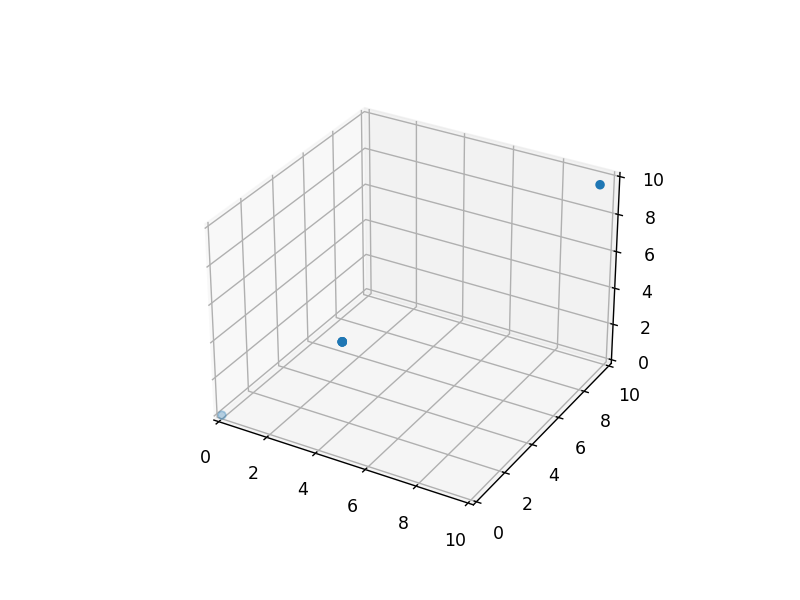

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation


#Creation of my particle
my_particles = RandomPArray(n=10, dims=[0, 10,0,10], seed=42)
duration = 100


##############################################################
#The creation of my figure                                   #
fig = plt.figure()                                           #
ax = fig.add_subplot(111, projection='3d')                   #
#Creating a global variable scat to store particle positions #
scat = ax.scatter([], [], [])                                #
##############################################################

def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([0, 10])
    ax.set_ylim3d([0, 10])
    ax.set_zlim3d([0, 10])
    scat = ax.scatter(
        [particle.getPos()[0] for particle in my_particles.particles],
        [particle.getPos()[1] for particle in my_particles.particles],
        [particle.getPos()[2] for particle in my_particles.particles]
    )
    return scat

def animate(frame):
    """
    This is the function that FuncAnimation will call at each time point.
    Basically What I will have to do here is to do what particles.whee() does for me.
    """
    for particle in my_particles.particles:
        particle.move()
        
    my_particles.calc_density()
    
    for particle in my_particles.particles:
        particle.calc_Pressure()
    
    my_particles.calc_accel()
    
    for particle in my_particles.particles:
        particle.calc_veloc()
        
    scat._offsets3d = (
        [particle.getPos()[0] for particle in my_particles.particles],
        [particle.getPos()[1] for particle in my_particles.particles],
        [particle.getPos()[2] for particle in my_particles.particles]
    )
    return scat,



ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=True, interval=5)
plt.show()


In [8]:
test_party = RandomPArray(n=10, dims=[0, 10,0, 20], seed=42)
temporary = ([], [], []) 

In [9]:
for particle in test_party.particles:
    particle.move()
        
test_party.calc_density()
    
for particle in test_party.particles:
    particle.calc_Pressure()
    
test_party.calc_accel()
    
for particle in test_party.particles:
    particle.calc_veloc()
        
temporary = (
    [particle.getPos()[0] for particle in test_party.particles],
    [particle.getPos()[1] for particle in test_party.particles],
    [particle.getPos()[2] for particle in test_party.particles])
print(temporary)

([1, 3, 1, 9, 0, 3, 0, 8, 7, 0], [0, 3, 8, 6, 1, 8, 8, 6, 9, 2], [4, 2, 1, 0, 3, 9, 3, 3, 4, 6])


<IPython.core.display.Javascript object>


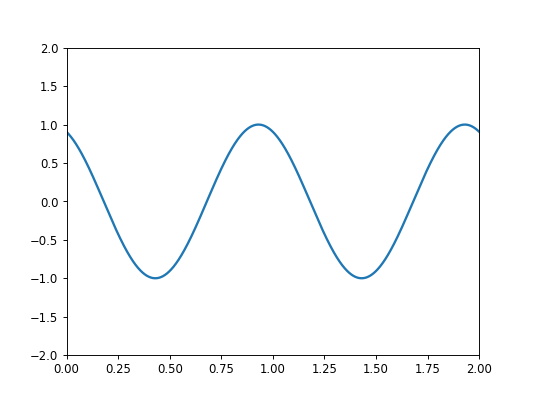

In [10]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
                                      
fig = plt.figure()                      
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)           


def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
plt.show()

In [11]:
my_particles = RandomPArray(n=100, dims=[0, 10], seed=42)

IndexError: list index out of range

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

#Creation of my particle
particles = RandomPArray(n=100, dims=[0, 10], seed=42)
duration = 100


def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([0, 10])
    ax.set_ylim3d([0, 10])
    ax.set_zlim3d([0, 10])
    scat = ax.scatter(
        [particle.getPos()[0] for particle in particles.particles],
        [particle.getPos()[1] for particle in particles.particles],
        [particle.getPos()[2] for particle in particles.particles]
    )
    return scat

def animate(frame):
    """
    This is the function that FuncAnimation will call at each time point.
    Basically What I will have to do here is to do what particles.whee() does for me.
    """
    for particle in particles.particles:
        particle.move()
    scat._offsets3d = (
        [particle.getPos()[0] for particle in particles.particles],
        [particle.getPos()[1] for particle in particles.particles],
        [particle.getPos()[2] for particle in particles.particles]
    )
    return scat,


###########################################
#The creation of my figure                #
fig = plt.figure()                        #
ax = fig.add_subplot(111, projection='3d')#
###########################################

ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=True)
plt.show()
